In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from sklearn.utils import shuffle

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import *
import tensorflow_addons as tfa
tf.__version__

'2.3.1'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Hyperparameters

In [7]:
PRE_TRAINED = './models/lstm.h5'
BEST_PATH = './models/lstm_transfer.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.002
EPSILON = 1e-06
BATCH_SIZE = 16

# Data loading

In [8]:
l = np.load('./results/2020_W/fw_ct_dataset.npz', allow_pickle=True)
data_indices = l['data_indices']
input_data = l['input_data']
output_label = l['output_label']
INPUT_MAXS = l['INPUT_MAXS']
INPUT_MINS = l['INPUT_MINS']
OUTPUT_MAX = l['OUTPUT_MAX']
OUTPUT_MIN = l['OUTPUT_MIN']

In [9]:
input_data = input_data.astype('float32')
output_label = output_label.astype('float32')

In [10]:
print(input_data.shape)
print(output_label.shape)

(312, 144, 9)
(312, 1)


In [11]:
print(INPUT_MAXS)
print(INPUT_MINS)

[  38.475   91.285 1313.3     78.755    7.857    4.908   31.6     55.877
   20.814]
[16.95875 16.435   -0.5957  63.447    3.579    1.797   15.75    40.295
  2.5625 ]


In [12]:
print(OUTPUT_MAX)
print(OUTPUT_MIN)

6.951840704324111
2.497831763925685


In [13]:
data_indices, input_data, output_label = shuffle(data_indices, input_data, output_label, random_state=3101)

In [14]:
N_TRAIN = int(input_data.shape[0]*.7/3)
N_DEV = int(input_data.shape[0]/3)
TRAIN_INDEX = [_ for _ in range(N_TRAIN)] + \
              [_ for _ in range(N_DEV, N_DEV+N_TRAIN)] + \
              [_ for _ in range(N_DEV*2, N_DEV*2+N_TRAIN)]
VAL_INDEX = [_ for _ in range(input_data.shape[0]) if _ not in TRAIN_INDEX]
train_input = input_data[TRAIN_INDEX, ...]
train_label = output_label[TRAIN_INDEX, ...]
train_indices = data_indices[TRAIN_INDEX]
val_input = input_data[VAL_INDEX, ...]
val_label = output_label[VAL_INDEX, ...]
val_indices = data_indices[VAL_INDEX]

In [15]:
print(f'number of data set: {input_data.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')

number of data set: 312
number of training set: 216
number of validation set: 96


In [16]:
with strategy.scope():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
    train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
    val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)

# Model construction

In [17]:
with strategy.scope():
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(256)),
        layers.LayerNormalization(),
        layers.Dense(32),
        layers.Dense(1)
    ])

In [18]:
cbs = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.5, patience=2, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0)

save = callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20) 

In [19]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model.compile(optimizer=opt, loss='mae')
    model.fit(train_dataset, epochs=TRAINING_EPOCHS, validation_data=val_dataset,
                  verbose=1, callbacks=[cbs, save, early_stop]) 

Epoch 1/200
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
13/14 [==========================>...] - ETA: 0s - loss: 5.7092INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repli

In [20]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model.compile(optimizer=opt, loss='mse')
    model.predict(val_dataset)
    model.load_weights(BEST_PATH)

In [21]:
model.evaluate(val_dataset)

6/6 [==============================] - 0s 7ms/step - loss: 0.0400


0.040003467351198196

In [22]:
pred_output = model.predict(val_input)

In [23]:
pred_output = pred_output*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN
val_label = val_label*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


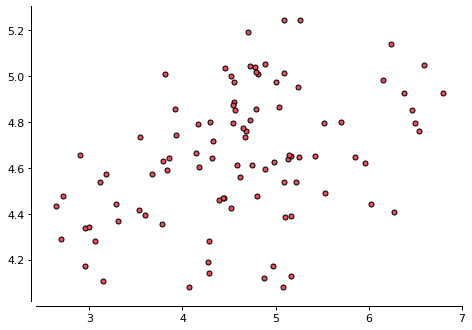

In [24]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(val_label, pred_output, 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [25]:
pred_df = pd.DataFrame(val_label, index=val_indices[:, 0], columns=['label'])
pred_df['pred'] = pred_output
pred_df.index = pd.DatetimeIndex(pred_df.index)
pred_df = pred_df.sort_index()

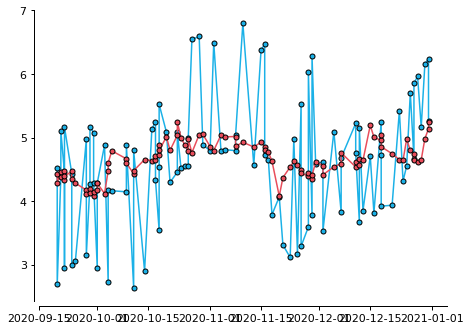

In [27]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['label'], '-o', ms=5, mec='k', c=cmap[4])
ax0.plot(pred_df.index, pred_df['pred'], 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()